# Projet P8 : POC - Vision Transformer

## Contexte

<b> MISSION : </b>

Réaliser un état de l’art sur une technique récente de modélisation de données texte ou de données image, l’analyser, la tester et la comparer à une approche plus classique réalisée précédemment.

 Concrètement :
- L’état de l’art devra concerner une technique datant de moins de 5 ans, présentée dans un article ;
- La technique doit être référencée sur des sites de recherche (Arxiv), des sites connus (par exemple fastml, machine learning mastery, kdnuggets, import AI, MIT tech review, MIT news ML) ou des newsletters de qualité comme data elixir et data science weekly ;
- Réaliser une preuve de concept qui met en oeuvre cette nouvelle technique avec les données texte ou image déjà exploitées précédemment ;
- Expliquer rapidement les concepts et techniques dans une note méthodologique et lors d’une présentation.entation.

## Etapes du projet :

### - Etape 1 : Choix du jeu de données
Choisissez rapidement les étapes (pre-processing, postprocessing, feature engineering etc.) et hypothèses qui resteront fixes pour le POC. L’idée n’est pas de refaire la pipeline de ML de bout en bout, mais de rapidement expérimenter.
### - Etape 2 : Choix de la méthode

Une piste à explorer parmi d’autres est le Transformer et ses variantes. C’est une architecture de réseaux de neurones qui constitue le fondement de toutes les méthodes de NLP et de vision modernes comme les LLM.

Soyez vigilant au temps de calcul de certaines méthodes état de l’art, surtout si vous envisagez un ré-entraînement d’architectures lourdes. Vous pouvez envisager de réduire la taille du jeu de données d'entraînement par exempl

### - Etape 3 : Implémentation
l’implémentation ainsi que la note méthodologique d’un Proof of Concept (POC) d’une technique de modélisation récente. )

### Environnement de travail et librairies

JAX is a Python library for accelerator-oriented array computation and program transformation, designed for high-performance numerical computing and large-scale machine learning.

In [1]:
import sys
# Mon environnement virtuel :
print(sys.executable)
# La version de Python dans mon environnement virtuel :
print(sys.version)

C:\Users\druar\anaconda3\envs\Formation_P8_2\python.exe
3.12.5 | packaged by Anaconda, Inc. | (main, Sep 12 2024, 18:18:29) [MSC v.1929 64 bit (AMD64)]


In [3]:
# Data
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
# Encodage
from sklearn import preprocessing
# Viz
import matplotlib.pyplot as plt
from matplotlib.image import imread
# Pytorch et Hugging Face Transformers
import transformers
from transformers import ViTForImageClassification
from transformers import ViTImageProcessor
import torch

C:\Users\druar\anaconda3\envs\Formation_P8_2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
print("Num GPUs Available: ", torch.cuda.device_count())

Num GPUs Available:  0


#### Utilisation de GPUs
  - Possibilité de passer par Google Colab pour utiliser les GPUs et gagner en temps de traitement.
  - Google Colaboratory : 
Colab is a hosted Jupyter Notebook service that requires no setup to use and provides free access to computing resources, including GPUs and TPUs. Colab is especially well suited to machine learning, data science, and education.
  - A noter : il n'est pas nécessaire de créer un compte pour utiliser Google Colab, possibilité de l'utiliser sans authentification, mais dans ce cas, on ne peut pas enregistrer les modifications directement sur notre Google Drive. Il faut dans ce cas télécharger le travail sous forme de fichier ou l'enregistrer sur un autre service de stockage en ligne..

## Etape 1 : Préparation du jeu de données

### 1. Préparation du DataSet

#### -- Chemin des images --

In [11]:
path = ".\\Flipkart\\Images\\"

#### -- Importation des articles --

In [14]:
articles_images = pd.read_csv(".\\Flipkart\\flipkart_com-ecommerce_sample_1050.csv")

In [16]:
# Selection des variables qui vont nous intéresser
vars = ['product_category_tree','image']
articles_images = articles_images[vars]
articles_images.head()

,product_category_tree,image
0,"[""Home Furnishing >> Curtains & Accessories >>...",55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",7b72c92c2f6c40268628ec5f14c6d590.jpg
2,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",64d5d4a258243731dc7bbb1eef49ad74.jpg
3,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",d4684dcdc759dd9cdf41504698d737d8.jpg
4,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",6325b6870c54cd47be6ebfbffa620ec7.jpg


#### -- Ajouter une colonne avec le lien complet de chaque image --

In [19]:
articles_images["image_path"] = path+articles_images['image']

#### -- Splitter la variable 'product_category_tree' en sous-catégories --

In [22]:
# Retier les signes [""] dans le texte de la variable
articles_images['product_category_tree'] = articles_images['product_category_tree'].str.slice(2, -2)
# Séparer les catégories en plusieurs colonnes
categories_split = articles_images['product_category_tree'].str.split(' >> ', expand=True)

# Renommer les colonnes pour une meilleure clarté
categories_split.columns = ['category_product', 'category_2', 'category_3','category_4', 'category_5', 'category_6','category_7']

# Joindre la colonne category_product avec le DataFrame original
articles_images = articles_images.join(categories_split['category_product'])
articles_images = articles_images.drop(columns='product_category_tree') # On supprime la variable d'origine
articles_images.head()

,image,image_path,category_product
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,C:\Users\druar\OneDrive\Documents\01_Formation...,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,C:\Users\druar\OneDrive\Documents\01_Formation...,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,C:\Users\druar\OneDrive\Documents\01_Formation...,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,C:\Users\druar\OneDrive\Documents\01_Formation...,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,C:\Users\druar\OneDrive\Documents\01_Formation...,Home Furnishing


#### -- Encodage de la catégorie de produit --

In [25]:
# Encodage de la catégorie de produit
le = preprocessing.LabelEncoder()
articles_images["category_code"] = le.fit_transform(articles_images["category_product"])
print(articles_images["category_code"])

0       4
1       0
2       0
3       4
4       4
       ..
1045    0
1046    0
1047    0
1048    0
1049    0
Name: category_code, Length: 1050, dtype: int32


<div class="alert alert-block alert-info">
    <b> A RETENIR : </b> 
    
- nous avons 1050 images de produits uniques dans l'échantillon de données avec leur catégorie
- il y a 7 catégories de produits
    
</div>

#### -- Exemples d'images par label --

Home Furnishing


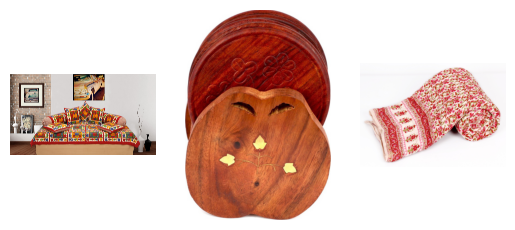

Baby Care


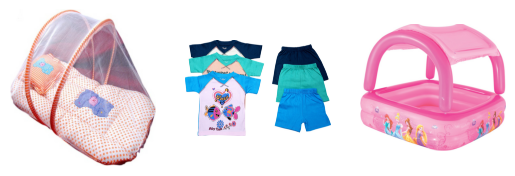

Watches


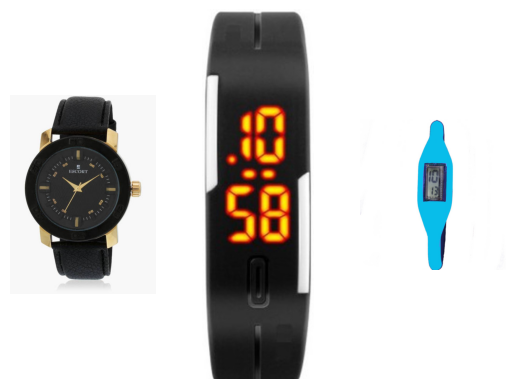

Home Decor & Festive Needs


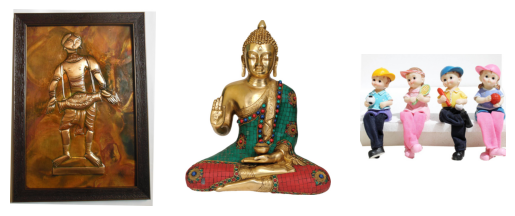

Kitchen & Dining


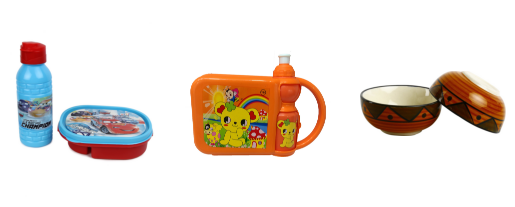

Beauty and Personal Care


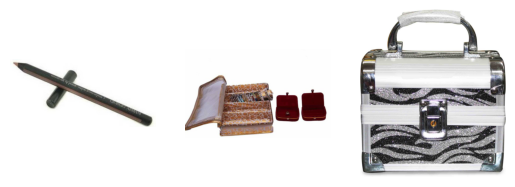

Computers


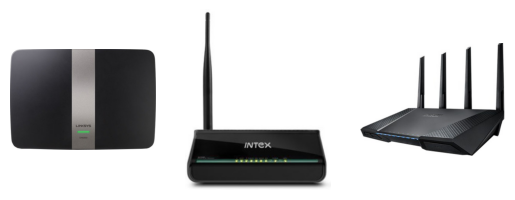

In [29]:
# Liste des labels uniques
list_labels = articles_images["category_product"].unique()

# Fonction pour obtenir les noms d'image pour une catégorie donnée
def list_fct(name):
    list_image_name = articles_images.loc[articles_images["category_product"] == name, "image"].tolist()
    return list_image_name

# Boucle pour chaque catégorie de produit
for name in list_labels:
    print(name)
    list_images = list_fct(name)

    # Affichage des images
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + list_images[i + 10]
        image = imread(filename)
        plt.imshow(image)
        plt.axis('off')
    
    plt.show()

#### -- Split des échantillons TEST-TRAIN-VALIDATION --

In [32]:
# Première étape : split en test (15%) et train_val (85%)
articles_images_train_val, articles_images_test = train_test_split(articles_images, test_size=0.15, random_state=42, stratify=articles_images['category_product'])
print(articles_images_test.shape, articles_images_train_val.shape)

(158, 4) (892, 4)


In [34]:
articles_images_test['category_product'].value_counts()

category_product
Home Furnishing               23
Home Decor & Festive Needs    23
Computers                     23
Watches                       23
Kitchen & Dining              22
Beauty and Personal Care      22
Baby Care                     22
Name: count, dtype: int64

In [36]:
# Deuxième étape : split de train_val en validation (20%) et train (80%)
articles_images_train, articles_images_val = train_test_split(articles_images_train_val, stratify=articles_images_train_val['category_product'], test_size=0.20, random_state=42)
print(articles_images_train.shape, articles_images_val.shape)

(713, 4) (179, 4)


In [38]:
articles_images_val['category_product'].value_counts()

category_product
Beauty and Personal Care      26
Home Furnishing               26
Baby Care                     26
Kitchen & Dining              26
Watches                       25
Computers                     25
Home Decor & Festive Needs    25
Name: count, dtype: int64

In [66]:
articles_images_val.groupby(['category_product', 'category_code']).size()

category_product            category_code
Baby Care                   0                26
Beauty and Personal Care    1                26
Computers                   2                25
Home Decor & Festive Needs  3                25
Home Furnishing             4                26
Kitchen & Dining            5                26
Watches                     6                25
dtype: int64

In [72]:
articles_images_train.groupby(['category_product', 'category_code']).size()

category_product            category_code
Baby Care                   0                102
Beauty and Personal Care    1                102
Computers                   2                102
Home Decor & Festive Needs  3                102
Home Furnishing             4                101
Kitchen & Dining            5                102
Watches                     6                102
dtype: int64

In [40]:
# Création d'un dictionnaire avec mes dataframes
datasets_dict = {
    'train': articles_images_train,
    'val': articles_images_val,
    'test': articles_images_test
}

### 2. Implémentation du modèle

#### -- Vérification des images --

In [44]:
# Fonction pour vérifier les images
def check_image_paths(df):
    valid_extensions = ('.jpg', '.jpeg', '.png')  # Extensions valides
    invalid_paths = []  # Liste pour les chemins invalides

    for index, row in df.iterrows():
        image_path = row['image_path']
        # Vérifier si le chemin d'image existe et a une extension valide
        if not os.path.isfile(image_path) or not image_path.lower().endswith(valid_extensions):
            invalid_paths.append(image_path)

    return invalid_paths

# Vérification des chemins d'image pour chaque DataFrame
invalid_train_paths = check_image_paths(articles_images_train)
invalid_val_paths = check_image_paths(articles_images_val)
invalid_test_paths = check_image_paths(articles_images_test)

# Afficher les résultats
if invalid_train_paths:
    print("Images invalides dans le train:", invalid_train_paths)

if invalid_val_paths:
    print("Images invalides dans la validation:", invalid_val_paths)

if invalid_test_paths:
    print("Images invalides dans le test:", invalid_test_paths)

if not invalid_train_paths and not invalid_val_paths and not invalid_test_paths:
    print("Toutes les images sont valides.")

Toutes les images sont valides.


Beauty and Personal Care


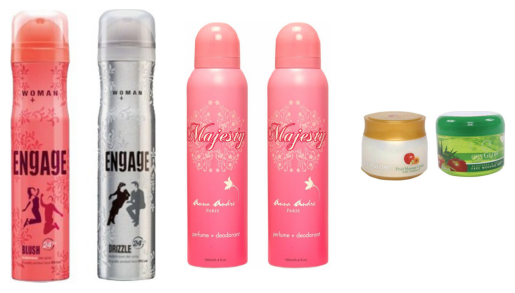

Home Furnishing


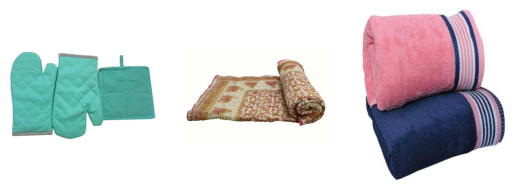

Watches


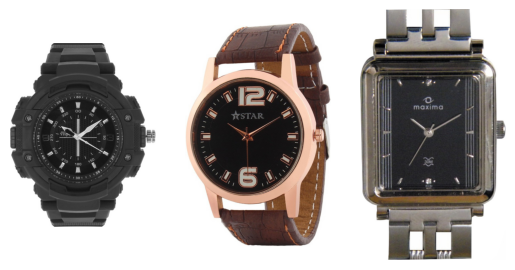

Baby Care


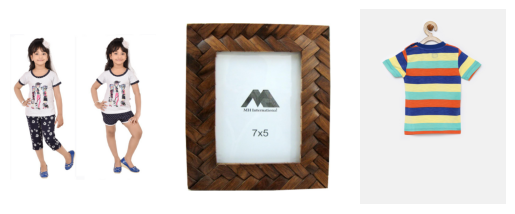

Computers


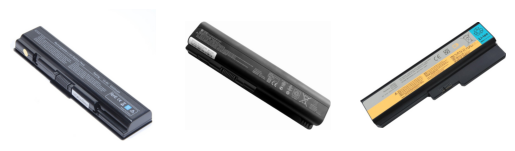

Home Decor & Festive Needs


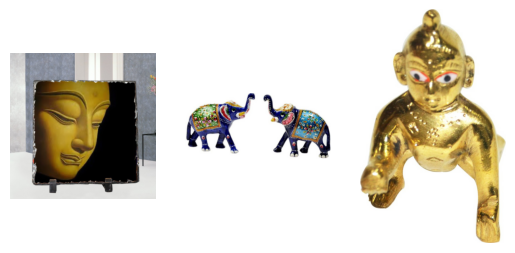

Kitchen & Dining


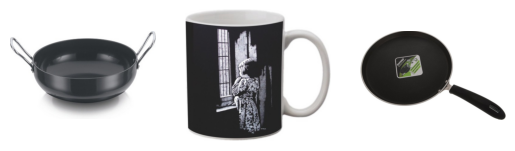

In [62]:
# Liste des labels uniques
list_labels = datasets_dict['val']['category_product'].unique()

# Fonction pour obtenir les noms d'image pour une catégorie donnée
def list_fct(name):
    list_image_name = datasets_dict['val'].loc[datasets_dict['val']["category_product"] == name, "image"].tolist()
    return list_image_name

# Boucle pour chaque catégorie de produit
for name in list_labels:
    print(name)
    list_images = list_fct(name)

    # Affichage des images
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + list_images[i + 10]
        image = imread(filename)
        plt.imshow(image)
        plt.axis('off')
    
    plt.show()

#### -- Préparation des images --

Créer un DataLoader pour charger les images à partir du chemin indiqué dans image_path.

In [160]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class ProductImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        image = Image.open(img_path).convert("RGB")
        # image = image.resize((512, 512)) # pour éviter l'avertissement des images qui dépassent la taille limite de pixels définie par PIL 
        label = self.dataframe.iloc[idx]['category_code']
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Définir les transformations (redimensionnement et normalisation pour ViT)
# + Augmentation des données
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Flips horizontaux aléatoires
    transforms.RandomRotation(10),  # Rotation aléatoire
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Changements aléatoires de couleur
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#### -- Chargement des images --

Charger les données avec le data loader.

In [164]:
# Charger les données
dataset_train = ProductImageDataset(dataframe=datasets_dict['train'], transform=transform)
train_loader = DataLoader(dataset_train, batch_size=64, shuffle=True)
dataset_val = ProductImageDataset(dataframe=datasets_dict['val'], transform=transform)
val_loader = DataLoader(dataset_val, batch_size=64, shuffle=True)
dataset_test = ProductImageDataset(dataframe=datasets_dict['test'], transform=transform)
test_loader = DataLoader(dataset_test, batch_size=64, shuffle=True)

#### -- Charger le modèle pré-entraîné ViT --

Nous allons utiliser le modèle ViT pré-entraîné sur ImageNet-21k et affiné sur ImageNet-2012.

In [168]:
from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch

# Charger le modèle et le feature extractor
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k')
# feature_extractor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

# Adapter la tête de classification à mes catégories (par exemple, 7 classes)
# model.classifier = torch.nn.Linear(in_features=768, out_features=7)

# Modifier la Tête de Classification : ajouter plus de couches fully connected entre les couches de ViT 
# et la sortie de classification pour rendre la tête plus complexe
model.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features=768, out_features=512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(in_features=512, out_features=7)  # 7 classes
)

# Utiliser un GPU si disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [172]:
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

# Définir l'optimiseur et la fonction de perte
optimizer = AdamW(model.parameters(), lr=1e-4)
loss_fn = CrossEntropyLoss()

# Boucle d'entraînement avec validation
num_epochs = 10
for epoch in range(num_epochs):
    # Entraînement
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).long()  # Conversion en LongTensor
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).long()  # Conversion en LongTensor
            outputs = model(images).logits
            val_loss += loss_fn(outputs, labels).item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

    val_accuracy = correct / len(val_dataset)
    print(f"Validation Accuracy: {val_accuracy}")

C:\Users\druar\anaconda3\envs\Formation_P8_2\Lib\site-packages\PIL\Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Validation Accuracy: 24.833333333333332
Validation Accuracy: 24.833333333333332
Validation Accuracy: 25.333333333333332
Validation Accuracy: 24.666666666666668
Validation Accuracy: 25.166666666666668
Validation Accuracy: 25.333333333333332
Validation Accuracy: 24.833333333333332
Validation Accuracy: 24.5
Validation Accuracy: 24.833333333333332
Validation Accuracy: 25.0


In [154]:
model.save_pretrained('./vit_finetunne_10epochs')

#### -- Prédictions du modèle --

In [77]:
from transformers import ViTForImageClassification, ViTImageProcessor
import torch

# Charger le modèle enregistré
model = ViTForImageClassification.from_pretrained('./vit_10epochs')
model.eval()  # Mode évaluation

# Charger le feature extractor (prétraitement des images)
feature_extractor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

RuntimeError: Error(s) in loading state_dict for ViTForImageClassification:
	size mismatch for classifier.weight: copying a param with shape torch.Size([7, 768]) from checkpoint, the shape in current model is torch.Size([2, 768]).
	size mismatch for classifier.bias: copying a param with shape torch.Size([7]) from checkpoint, the shape in current model is torch.Size([2]).
	You may consider adding `ignore_mismatched_sizes=True` in the model `from_pretrained` method.